# Imports

In [90]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import dill

In [5]:
%matplotlib inline

In [6]:
# dill.dump_session('CDC_F.db')

In [7]:
# dill.load_session('CDC_F.db')

In [8]:
# from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
# from sklearn_pandas import DataFrameMapper, gen_features

# #from mpl_toolkits import mplot3d
# from sklearn.pipeline import Pipeline
# from sklearn.base import clone, TransformerMixin, BaseEstimator

In [9]:
SEED = 73 # random seed

# Data reading

## Reading

In [10]:
csvs = [x for x in os.listdir('data/') if x.endswith('.csv')] # читаем имена файлов .csv

In [11]:
needed_csvs = []

for s in csvs:
    if 'CDC' in s:
        needed_csvs.append(s)

In [12]:
nms = [x.split('.')[0] for x in needed_csvs] # список имён будущих датафреймов сделаем без расширений

In [13]:
nms

['AP1_CDCFrontier_LD',
 'AP1_CDCFrontier_SD',
 'FD_CDCFrontier_LD',
 'FD_CDCFrontier_SD',
 'FTa1_CDCFrontier_LD',
 'FTa1_CDCFrontier_SD',
 'FTa2_CDCFrontier_LD',
 'FTa2_CDCFrontier_SD',
 'FTa3_CDCFrontier_LD',
 'FTa3_CDCFrontier_SD',
 'FTb_CDCFrontier_LD',
 'FTb_CDCFrontier_SD',
 'FTc_CDCFrontier_LD',
 'FTc_CDCFrontier_SD',
 'LFY_CDCFrontier_LD',
 'LFY_CDCFrontier_SD',
 'TFL1a_CDCFrontier_LD',
 'TFL1a_CDCFrontier_SD',
 'TFL1c_CDCFrontier_LD',
 'TFL1c_CDCFrontier_SD']

In [14]:
for i in range(len(nms)):
    nms[i] = '_'.join(nms[i].split('_CDCFrontier_'))

In [15]:
nms

['AP1_LD',
 'AP1_SD',
 'FD_LD',
 'FD_SD',
 'FTa1_LD',
 'FTa1_SD',
 'FTa2_LD',
 'FTa2_SD',
 'FTa3_LD',
 'FTa3_SD',
 'FTb_LD',
 'FTb_SD',
 'FTc_LD',
 'FTc_SD',
 'LFY_LD',
 'LFY_SD',
 'TFL1a_LD',
 'TFL1a_SD',
 'TFL1c_LD',
 'TFL1c_SD']

In [16]:
data = {}
for i in range(len(nms)):
    data[nms[i]] = pd.read_csv('data/' + needed_csvs[i], header=None, names = ['days', 'rltv_transcription_lvl', 'std_error'])

In [17]:
print(len(data['FTa2_LD']))
print(len(data['FTa2_SD']))

15
14


## Delete last

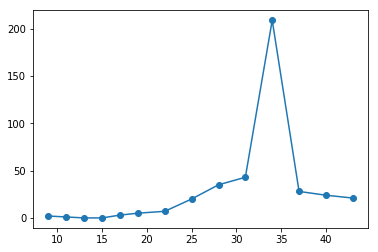

In [18]:
plt.plot(data['AP1_SD'].days, data['AP1_SD'].rltv_transcription_lvl, 'o-');

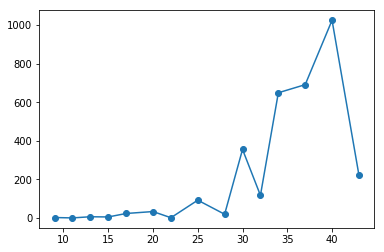

In [19]:
plt.plot(data['AP1_LD'].days, data['AP1_LD'].rltv_transcription_lvl, 'o-');

let's remove last measurements:

In [20]:
for name in data.keys():
    if name.endswith('LD'):
        data[name] = data[name].iloc[:-1,:]
    else:
        data[name] = data[name].iloc[:-3,:]

In [21]:
print(len(data['FTa2_LD']))
print(len(data['FTa2_SD']))

14
11


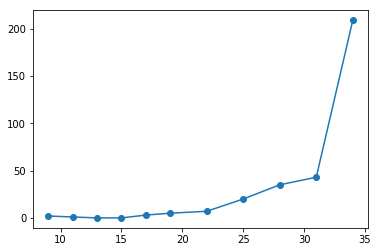

In [22]:
plt.plot(data['AP1_SD'].days, data['AP1_SD'].rltv_transcription_lvl, 'o-');

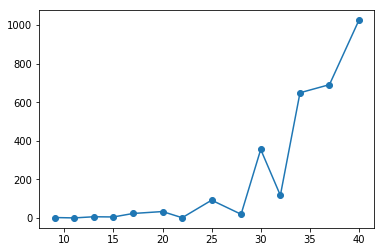

In [23]:
plt.plot(data['AP1_LD'].days, data['AP1_LD'].rltv_transcription_lvl, 'o-');

# Resampling

## Create samples base by days

In [24]:
for i in data['AP1_LD']['days']:
    print(i, end=' ')

9 11 13 15 17 20 22 25 28 30 32 34 37 40 

In [25]:
samples_by_day = {}
for name in nms:
    samples_by_day[name] = {}

for name in nms:
    for i in range(len(data[name])):
        mean = data[name].iloc[i]['rltv_transcription_lvl']
        std = data[name].iloc[i]['std_error']
        samples_by_day[name][data[name].iloc[i]['days']] = normal(mean, std, 100)

## Create whole-time samples

In [26]:
names = set(n[:-3] for n in nms)

Создадим два словаря (будущих датафрейма): ключ -- ген, значения -- уровень в определённый день.
Каждый будет содержать уровни экспрессий в определённый момент. Так как для SD 11 дней, а для LD 14, то один полный эксперимент для каждого гена составляет 25 наблюдений. Следовательно, возьмём 40 таких экспериментов, чтобы набрать 1000 наблюдений в общем.

In [27]:
synth_LD = {}
synth_SD = {}

for name in names:
    synth_LD[name] = []
    synth_SD[name] = []



for j in range(40):
    for name in nms:
        whole_set = [] # искуственный эксперимент, охватывающий все дни
        days = list(samples_by_day[name].keys())
        
        # перебираем по дням, из каждого равновероятно берём значение:
        for day in days:
            whole_set.append(random.choice(samples_by_day[name][day]))
        
        # сдвиг на полдня вниз для FT генов:
        if name.startswith('FT'):
            FT_set = [whole_set[0]]
            for i in range(1, len(whole_set)):
                FT_set.append((whole_set[i-1] + whole_set[i]) / 2)
            whole_set = FT_set
        
        if name.endswith('LD'):
            for element in whole_set:
                synth_LD[name[:-3]].append(element)
        else:
            for element in whole_set:
                synth_SD[name[:-3]].append(element)

synth_LD = pd.DataFrame(synth_LD)
synth_SD = pd.DataFrame(synth_SD)

In [28]:
synth_LD.tail()

,TFL1c,FTa1,FTc,AP1,TFL1a,FTb,LFY,FD,FTa2,FTa3
555,25.940216,8.0,7.0,357.600306,21.554527,81.5,42.097296,77.715513,25.793367,1.868871
556,9.500557,3.5,7.0,102.813977,14.305077,57.5,56.443301,43.774118,40.907887,2.318871
557,33.137658,15.0,0.0,743.443033,24.805841,76.5,75.268480,72.886758,39.000000,-12.940203
558,13.844717,17.5,0.0,945.488210,14.582530,82.5,84.705078,116.762507,48.000000,-11.040203
559,53.960087,23.5,1.0,532.373394,15.740749,49.0,77.024063,140.949534,60.208783,19.500000


In [29]:
synth_SD['LD'] = 0
synth_LD['LD'] = 1

In [30]:
synth_LD.head()

,TFL1c,FTa1,FTc,AP1,TFL1a,FTb,LFY,FD,FTa2,FTa3,LD
0,24.342710,2.0,0.0,-131.102682,22.710053,3.0,7.769003,32.974898,8.000000,0.90,1
1,23.514225,1.0,0.0,55.671931,18.019289,5.0,13.476494,37.649259,9.500000,0.70,1
2,35.302186,0.5,0.0,19.862311,17.631873,6.5,9.939423,49.224792,20.000000,0.65,1
3,40.160673,3.0,0.0,-35.598767,35.731942,17.0,57.545745,38.182131,44.500000,5.50,1
4,37.304047,7.0,0.0,17.617073,39.422296,20.0,73.280524,106.095268,56.746942,5.75,1


In [31]:
data['FTa2_LD']

,days,rltv_transcription_lvl,std_error
0,9,8,0
1,11,11,0
2,13,29,0
3,15,60,0
4,17,50,18
5,20,86,0
6,22,18,0
7,25,68,19
8,28,37,23
9,30,52,24


## Data joining

In [32]:
tr_lvls_combined = pd.concat([synth_LD, synth_SD], ignore_index=True)

**пока что дропнем тип дня**

In [33]:
tr_lvls_combined = tr_lvls_combined.drop('LD', axis = 1)

In [34]:
tr_lvls_combined.head()

,TFL1c,FTa1,FTc,AP1,TFL1a,FTb,LFY,FD,FTa2,FTa3
0,24.342710,2.0,0.0,-131.102682,22.710053,3.0,7.769003,32.974898,8.000000,0.90
1,23.514225,1.0,0.0,55.671931,18.019289,5.0,13.476494,37.649259,9.500000,0.70
2,35.302186,0.5,0.0,19.862311,17.631873,6.5,9.939423,49.224792,20.000000,0.65
3,40.160673,3.0,0.0,-35.598767,35.731942,17.0,57.545745,38.182131,44.500000,5.50
4,37.304047,7.0,0.0,17.617073,39.422296,20.0,73.280524,106.095268,56.746942,5.75


In [35]:
tr_lvls_combined = tr_lvls_combined.reindex(sorted(tr_lvls_combined.columns), axis=1)

In [36]:
tr_lvls_combined.head(1)

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c
0,-131.102682,32.974898,2.0,8.0,0.9,3.0,0.0,7.769003,22.710053,24.34271


# Data preparation

## Split the data

Split into factors-targets and train-test

Для начала построим модель зависимости AP1 от всех других генов:

In [37]:
current_target = 'AP1'

In [38]:
target = tr_lvls_combined['AP1']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tr_lvls_combined.drop('AP1', axis = 1), target,
                                                    test_size = 0.25, random_state=SEED, shuffle=True)

## Data standartization

следует изменить стандартизацию так, чтобы запоминать параметры масштабирования ТП и дальше использовать именно их, или же вообще стоит отказаться от этого шага.

In [40]:
def standartize_train_test(X_train, X_test):
    st_scaler = StandardScaler()
    
    standartized_train = st_scaler.fit_transform(X_train.values)
    standartized_test = st_scaler.transform(X_test.values)
    
    standartized_train = pd.DataFrame(standartized_train, columns=X_train.columns)
    standartized_test = pd.DataFrame(standartized_test, columns=X_test.columns)
    
    return standartized_train, standartized_test, st_scaler

In [226]:
# def minmax_train_test(X_train, X_test):
#     st_scaler = MinMaxScaler()
    
#     standartized_train = st_scaler.fit_transform(X_train.values)
#     standartized_test = st_scaler.transform(X_test.values)
    
#     standartized_train = pd.DataFrame(standartized_train, columns=X_train.columns)
#     standartized_test = pd.DataFrame(standartized_test, columns=X_test.columns)
    
#     return standartized_train, standartized_test

In [41]:
X_train_standartized, X_test_standartized, st_scaler = standartize_train_test(X_train, X_test)

In [101]:
with open('scaler.cached', 'wb') as file:
    dill.dump(st_scaler, file)

In [42]:
X_train_standartized.describe()

,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c
count,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02
mean,2.856974e-16,4.366877e-17,3.937591e-17,-9.821773e-17,-1.746751e-16,7.864774e-17,-6.631732e-17,1.921056e-16,-1.983598e-16
std,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00,1.000667e+00
min,-1.429880e+00,-1.019577e+00,-1.321160e+00,-1.319970e+00,-8.280165e-01,-5.854200e-01,-1.555123e+00,-1.605349e+00,-2.892337e+00
25%,-6.775345e-01,-8.194943e-01,-6.592145e-01,-4.140967e-01,-7.468787e-01,-5.854200e-01,-6.025577e-01,-6.379763e-01,-6.273966e-01
50%,-2.853077e-01,-3.020664e-01,-3.507990e-01,-3.307730e-01,-6.170582e-01,-3.490812e-01,-2.716893e-01,-2.727652e-01,-1.661595e-01
75%,3.334095e-01,2.476118e-01,8.578747e-01,-5.557561e-02,7.622841e-01,-7.702895e-03,1.435920e-01,2.717481e-01,3.173000e-01
max,4.462229e+00,2.248436e+00,3.070887e+00,5.554221e+00,2.222764e+00,3.090962e+00,6.509242e+00,5.401141e+00,4.225805e+00


## Write prepared data to file for further usage

In [42]:
X_train.to_csv('data/prepared/X_train.csv')
X_test.to_csv('data/prepared/X_test.csv')

In [43]:
y_train.to_csv('data/prepared/y_train.csv', header = current_target)
y_test.to_csv('data/prepared/y_test.csv', header = current_target)

In [44]:
X_train_standartized.to_csv('data/prepared/X_train_std.csv')
X_test_standartized.to_csv('data/prepared/X_test_std.csv')

# Regression models

## Linear model

In [45]:
linear_model = LinearRegression()

In [46]:
linear_model.fit(X_train_standartized, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
train_pred = linear_model.predict(X_train_standartized)

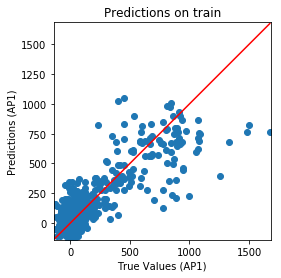

In [48]:
plt.scatter(y_train, train_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.title('Predictions on train')
plt.xlim(min(y_train) -10, max(y_train)+10)
plt.ylim(min(y_train) -10, max(y_train)+10)
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [49]:
np.corrcoef(train_pred, y_train)

array([[1.        , 0.83312176],
       [0.83312176, 1.        ]])

In [50]:
mean_squared_error(y_train, train_pred)

22469.103797302898

In [51]:
predictions = linear_model.predict(X_test_standartized)

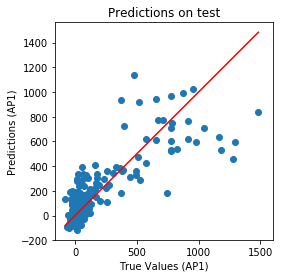

In [52]:
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.title('Predictions on test')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [53]:
mean_squared_error(y_test, predictions)

25533.44093136099

In [54]:
np.corrcoef(predictions, y_test)

array([[1.        , 0.82491261],
       [0.82491261, 1.        ]])

## SVM regression

In [98]:
print(st_scaler.mean_)
print(st_scaler.var_)

[49.38000703  8.14367619 67.90661448  6.22701331 25.51266667  1.11466667
 68.89053533 20.91872261 26.10695746]
[5.42512982e+02 5.62036840e+01 2.05607384e+03 1.71126091e+02
 9.49366173e+02 3.62539156e+00 6.64971332e+03 1.34728822e+02
 1.74150078e+02]


In [55]:
svm_reg = SVR(kernel='rbf')

In [70]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'gamma': np.geomspace(0.0001, 10, 6),
    'C': np.geomspace(0.0001, 1000, 8),
    'epsilon': np.geomspace(0.0001, 10, 6)
    #'learning_rate_init': np.geomspace(0.001, 0.1, 3)
}

gs = GridSearchCV(svm_reg, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [71]:
%%time
gs.fit(X_train_standartized, y_train);

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 265 tas

Wall time: 39.6 s


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   39.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=73, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'epsilon': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [72]:
gs.best_params_

{'C': 1000.0, 'epsilon': 10.0, 'gamma': 0.1}

In [73]:
svr = gs.best_estimator_

In [74]:
train_pred = svr.predict(X_train_standartized)

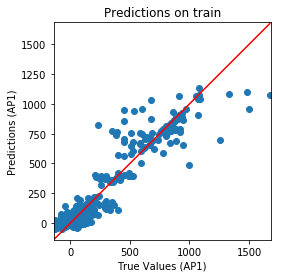

In [75]:
plt.scatter(y_train, train_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.title('Predictions on train')
plt.xlim(min(y_train) -10, max(y_train)+10)
plt.ylim(min(y_train) -10, max(y_train)+10)
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [86]:
np.corrcoef(train_pred, y_train)[1,0]

0.9484487761000225

In [77]:
mean_squared_error(y_train, train_pred)

7405.212903139256

In [79]:
predictions = svr.predict(X_test_standartized)

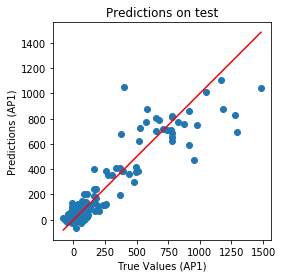

In [80]:
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.title('Predictions on test')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [81]:
mean_squared_error(y_test, predictions)

10791.762753105986

In [91]:
np.corrcoef(predictions, y_test)[1,0]

0.9302702198292685

## NN model

### Model

len(hidden_layer_sizes) = n_layers

* Стоит делать Gread search по $\alpha$, momentum, возможно, начальный learning_rate_init
* Попробовать другие активационные функции
* другая архитектура


In [250]:
model = MLPRegressor(hidden_layer_sizes=(9, 4), solver='sgd', validation_fraction=0.25,
                     n_iter_no_change=50, max_iter=5000, early_stopping=True,
                     learning_rate='adaptive', alpha=1e-4, activation='logistic')

### Rough tuning

In [251]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'alpha': np.geomspace(0.00001, 0.01, 4),
    'activation' : ['logistic', 'relu']
    #'learning_rate_init': np.geomspace(0.001, 0.1, 3)
}

gs = GridSearchCV(model, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [252]:
%%time
gs.fit(X_train_standartized, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    9.2s remaining:    0.4s


KeyboardInterrupt: 

In [253]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

### Fine tuning

In [254]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'alpha': np.linspace(1e-5, 1e-2, 20).round(5)
}

gs = GridSearchCV(model, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [255]:
%%time
gs.fit(X_train_standartized, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished


Wall time: 33.5 s


GridSearchCV(cv=KFold(n_splits=5, random_state=73, shuffle=True),
       error_score='raise-deprecating',
       estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(9, 4), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.25, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.00e-05, 5.40e-04, 1.06e-03, 1.59e-03, 2.11e-03, 2.64e-03,
       3.16e-03, 3.69e-03, 4.22e-03, 4.74e-03, 5.27e-03, 5.79e-03,
       6.32e-03, 6.85e-03, 7.37e-03, 7.90e-03, 8.42e-03, 8.95e-03,
       9.47e-03, 1.00e-02])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_

In [257]:
gs.best_params_

{'alpha': 0.00054}

In [295]:
model = gs.best_estimator_

### Prediction

In [296]:
train_pred = model.predict(X_train_standartized)

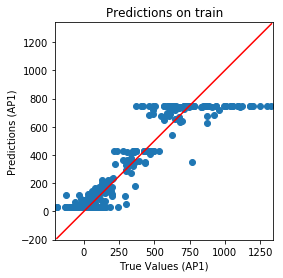

In [415]:
plt.scatter(y_train, train_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.title('Predictions on train')
plt.xlim(min(y_train) -10, max(y_train)+10)
plt.ylim(min(y_train) -10, max(y_train)+10)
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [261]:
np.corrcoef(train_pred, y_train)

array([[1.        , 0.94184787],
       [0.94184787, 1.        ]])

In [409]:
mean_squared_error(y_train, train_pred)

8649.55790904465

In [302]:
predictions = model.predict(X_test_standartized)

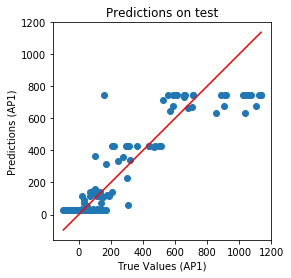

In [411]:
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.title('Predictions on test')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [304]:
mean_squared_error(y_test, predictions)

10625.776221357895

In [305]:
np.corrcoef(predictions, y_test)

array([[1.       , 0.9316579],
       [0.9316579, 1.       ]])

In [84]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,1.06257,1.14733,1.03064,1.16688,1.126,1.37143,1.06317,1.07434,1.18185,1.15112,1.14983,1.30173,1.52672,1.31759,1.30267,1.35757,1.25185,1.49751,1.29754,1.18252
std_fit_time,0.140922,0.14733,0.101183,0.21017,0.121303,0.138057,0.0921169,0.0861866,0.182369,0.0968926,0.114012,0.245682,0.197442,0.192389,0.189767,0.124749,0.237436,0.347471,0.178523,0.0744981
mean_score_time,0.00319166,0.00319185,0.00299101,0.00339146,0.0039896,0.00319138,0.00299225,0.00299215,0.00319185,0.00358715,0.00319157,0.00478702,0.00339408,0.00319157,0.00598245,0.00359073,0.0031888,0.00379038,0.00358992,0.00419073
std_score_time,0.000398898,0.000398803,2.42391e-06,0.000488753,0.00199502,0.000399041,2.86102e-07,3.69356e-07,0.00039916,0.000801009,0.000399423,0.00159592,0.000804329,0.000397992,0.00550002,0.00119667,0.000400853,0.00116311,0.000797892,0.00132525
param_alpha,1e-05,6e-05,0.00011,0.00017,0.00022,0.00027,0.00032,0.00037,0.00043,0.00048,0.00053,0.00058,0.00064,0.00069,0.00074,0.00079,0.00084,0.0009,0.00095,0.001
params,{'alpha': 1e-05},{'alpha': 6e-05},{'alpha': 0.00011},{'alpha': 0.00017},{'alpha': 0.00022},{'alpha': 0.00027},{'alpha': 0.00032},{'alpha': 0.00037},{'alpha': 0.00043},{'alpha': 0.00048},{'alpha': 0.00053},{'alpha': 0.00058},{'alpha': 0.00064},{'alpha': 0.00069},{'alpha': 0.00074},{'alpha': 0.00079},{'alpha': 0.00084},{'alpha': 0.0009},{'alpha': 0.00095},{'alpha': 0.001}
split0_test_neg_mean_squared_error,-10446.2,-9829.79,-9770.31,-8723.12,-11091.4,-8195.56,-8163.06,-10005.7,-7758.18,-9580.52,-8827.82,-15420.5,-9227.67,-9549.69,-7304.3,-8375.17,-8909.25,-8427.8,-10817.8,-8931.66
split1_test_neg_mean_squared_error,-7612.98,-6852.09,-9513.9,-7543.9,-10324,-6479.91,-8769.73,-6981.53,-10065.6,-7336.65,-9292.78,-9775.72,-7087.2,-7774.28,-7820.1,-8958.12,-12984.1,-7910.65,-7695.4,-7254.61
split2_test_neg_mean_squared_error,-8420.44,-12166.3,-13569.5,-8108.78,-8939.53,-10420.8,-9685.89,-10967.6,-6592.29,-6775.96,-10693.8,-8849.55,-10206.7,-10649.5,-9470.32,-7929.7,-8740.56,-12421.4,-11611.7,-7298.98
split3_test_neg_mean_squared_error,-11788.7,-12291.2,-11019.5,-12021.5,-12267.1,-11537,-10515,-10497.5,-11681.4,-10421.6,-13666.5,-11556.3,-10268.4,-11337.9,-10306.7,-12040.6,-11356.4,-11507.2,-11268.1,-9604.46


In [306]:
model.loss_

3591.7413163785145

Коэффициент детерминации $R^2$:

In [307]:
model.score(X_test_standartized, y_test)

0.860430926358663

In [374]:
model.coefs_

[array([[ 2.51174827e+00,  7.51267107e+00,  7.56758119e-01,
          6.56789408e+00,  9.77092762e-01,  3.53718052e+00,
          7.38883610e-01,  2.13014404e+00,  6.11925106e+00,
          1.19897931e+00,  2.30063840e+00,  6.77209671e-01,
          1.13061762e+00,  6.46653250e+00,  1.39389802e+00,
          5.27680070e+00,  1.21612593e+00,  1.28896634e+00],
        [ 3.29198884e+00,  1.50126129e+00,  1.60195838e+00,
          2.34297538e-01,  1.38635688e+00,  3.76008657e+00,
          1.70710662e+00,  2.02893943e+00,  3.07791916e+00,
          1.99057366e+00,  5.84368389e-01,  1.76134934e+00,
          1.70150159e+00,  1.90400814e+00,  1.99524010e+00,
          7.46615170e-01,  2.01945425e+00,  1.84315750e+00],
        [ 2.15808091e+00,  1.15617792e+00, -7.82633187e-01,
         -8.07387216e-01, -1.88046287e+00, -7.87249738e-01,
         -1.55810818e+00, -6.91982992e-01,  1.55161213e+00,
         -3.09737981e+00, -1.09954142e-01, -8.44344663e-01,
         -1.90472976e+00,  9.86466290e

### Prediction on real

In [324]:
true_lvls_SD = pd.DataFrame(data['AP1_SD'].days.values, columns = ['days'])
true_lvls_LD = pd.DataFrame(data['AP1_LD'].days.values, columns = ['days'])

for k in data.keys():
    if k.endswith('LD'):
        true_lvls_LD[k] = data[k].rltv_transcription_lvl.values
    else:
        true_lvls_SD[k] = data[k].rltv_transcription_lvl.values

In [325]:
true_lvls_LD.head()

,days,AP1_LD,FD_LD,FTa1_LD,FTa2_LD,FTa3_LD,FTb_LD,FTc_LD,LFY_LD,TFL1a_LD,TFL1c_LD
0,9,2,31.53,2,8,0.9,3,0,6.4,22.021,25.556
1,11,0,47.62,0,11,0.5,7,0,12.1,20.489,25.263
2,13,6,45.41,1,29,0.8,6,0,21.4,27.397,32.982
3,15,5,40.89,5,60,10.2,28,0,56.8,33.074,39.708
4,17,23,79.47,9,50,1.3,12,0,77.1,42.561,32.222


In [326]:
true_lvls_SD = true_lvls_SD.rename(columns=lambda x: x[:-3])

true_lvls_LD = true_lvls_LD.rename(columns=lambda x: x[:-3])

In [327]:
true_lvls = true_lvls_LD.append(true_lvls_SD, ignore_index=True)

true_lvls = true_lvls.drop('d', axis =1)

true_lvls = true_lvls.reindex(sorted(true_lvls.columns), axis=1)

In [432]:
true_AP1_pred = model.predict(StandardScaler().fit_transform(true_lvls.drop(current_target, axis=1)))

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [329]:
len(true_lvls['AP1'])

25

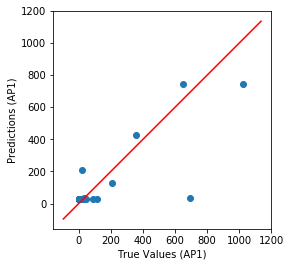

In [433]:
plt.scatter(true_lvls['AP1'], true_AP1_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

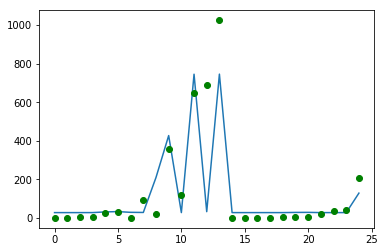

In [434]:
plt.plot(list(range(len(true_AP1_pred))), true_AP1_pred, '-')
plt.plot(list(range(len(true_AP1_pred))), true_lvls['AP1'], 'go')

### LD & SD separate

#### LD

In [447]:
true_AP1_LD_pred = model.predict(st_scaler.fit_transform(true_lvls_LD.drop([current_target, 'd'], axis=1)))

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


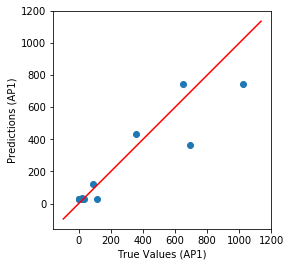

In [448]:
plt.scatter(true_lvls_LD['AP1'], true_AP1_LD_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [462]:
np.corrcoef(true_lvls_LD['AP1'], true_AP1_LD_pred)

array([[1.        , 0.93635056],
       [0.93635056, 1.        ]])

In [463]:
mean_squared_error(true_lvls_LD['AP1'], true_AP1_LD_pred)

15118.910168443937

Text(0.5, 1.0, 'AP1 expression level for LD conditions')

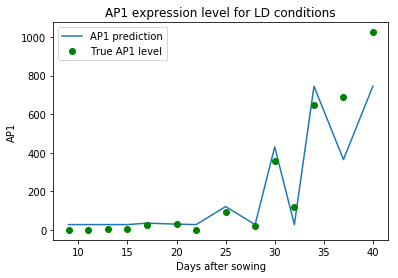

In [449]:
plt.plot(true_lvls_LD['d'], true_AP1_LD_pred, '-')
plt.plot(true_lvls_LD['d'], true_lvls_LD['AP1'], 'go')
plt.xlabel('Days after sowing')
plt.ylabel('AP1')
plt.legend(['AP1 prediction', 'True AP1 level'])
plt.title('AP1 expression level for LD conditions')

#### SD

In [450]:
true_AP1_SD_pred = model.predict(st_scaler.transform(true_lvls_SD.drop([current_target, 'd'], axis=1)))

C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


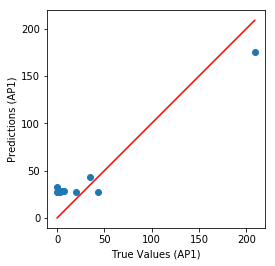

In [461]:
plt.scatter(true_lvls_SD['AP1'], true_AP1_SD_pred)
plt.plot([min(true_lvls_SD['AP1']), max(true_lvls_SD['AP1'])], 
         [min(true_lvls_SD['AP1']), max(true_lvls_SD['AP1'])], 'r')
plt.xlabel('True Values' + ' (' + current_target + ')')
plt.ylabel('Predictions' + ' (' + current_target + ')')
plt.axis('equal')
plt.axis('square')
plt.show()
# plt.xlim([0,3])
# plt.ylim([0,3])

In [464]:
np.corrcoef(true_lvls_SD['AP1'], true_AP1_SD_pred)

array([[1.        , 0.97566031],
       [0.97566031, 1.        ]])

In [465]:
mean_squared_error(true_lvls_SD['AP1'], true_AP1_SD_pred)

571.0705380972578

Text(0.5, 1.0, 'AP1 expression level for SD conditions')

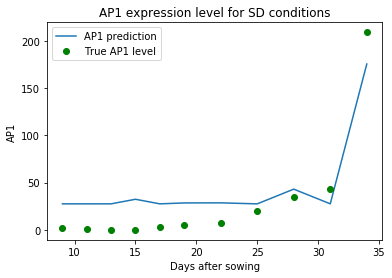

In [452]:
plt.plot(true_lvls_SD['d'], true_AP1_SD_pred, '-')
plt.plot(true_lvls_SD['d'], true_lvls_SD['AP1'], 'go')
plt.xlabel('Days after sowing')
plt.ylabel('AP1')
plt.legend(['AP1 prediction', 'True AP1 level'])
plt.title('AP1 expression level for SD conditions')

# Gene interaction analysis

**Mutants**

In [335]:
true_lvls

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c
0,2,31.53,2,8,0.900,3,0.0,6.4,22.021,25.556
1,0,47.62,0,11,0.500,7,0.0,12.1,20.489,25.263
2,6,45.41,1,29,0.800,6,0.0,21.4,27.397,32.982
3,5,40.89,5,60,10.200,28,0.0,56.8,33.074,39.708
4,23,79.47,9,50,1.300,12,0.0,77.1,42.561,32.222
5,33,71.69,40,86,2.500,58,0.0,48.9,54.798,67.895
6,1,25.86,10,18,3.400,7,0.0,16.0,8.314,11.930
7,92,43.31,10,68,4.700,127,0.0,45.1,18.325,25.731
8,19,45.20,10,37,2.100,61,0.0,27.7,15.851,18.713
9,355,81.78,6,52,14.800,102,14.0,50.9,22.232,29.766


In [273]:
true_lvls.shape

(25, 10)

In [366]:
true_medians = true_lvls.describe().loc['50%']

In [453]:
mutants = pd.DataFrame(true_lvls, copy=True)
mutants = mutants.drop('AP1', axis=1)

In [367]:
true_medians

AP1      19.000
FD       43.900
FTa1      6.000
FTa2     62.000
FTa3      1.849
FTb       7.000
FTc       0.000
LFY      50.900
TFL1a    18.325
TFL1c    25.263
Name: 50%, dtype: float64

In [456]:
mutants_out = pd.DataFrame(mutants, copy=True)

for k in mutants_out.keys():
    mutants_out[k] = 0

In [458]:
for k in mutants.keys():
    mutants[k] = 0
    mutants_out[k] = model.predict(st_scaler.transform(mutants))
    mutants[k] = true_lvls[k]

C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package 

In [459]:
mutants_out

,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c
0,27.538446,27.538533,27.538534,27.538490,27.538611,27.538527,27.538529,27.568166,27.538526
1,27.538447,27.540702,27.544172,27.540104,27.563020,27.540702,27.543920,30.906509,27.612313
2,27.538441,27.538444,27.538453,27.538444,27.538450,27.538444,27.538448,27.589562,27.540314
3,27.538467,27.539442,27.538463,27.617880,27.687118,27.580245,27.538441,27.567225,27.539347
4,27.763900,30.664599,28.284885,33.874526,35.866271,35.173997,27.555994,27.923836,49.043964
5,79.082988,29.202429,30.800660,30.129109,30.773952,30.027268,30.650254,738.671350,92.247449
6,27.570137,27.566517,27.614776,27.571742,27.568966,27.572983,27.572573,27.907565,27.636654
7,122.594328,115.285676,123.095759,122.140229,27.563001,121.058884,122.194013,28.421636,136.577984
8,27.546139,27.538735,28.340202,27.560580,28.581994,27.564811,27.565047,239.071292,34.197684
9,149.362136,652.788064,660.954247,727.236859,103.405596,31.556751,476.808672,391.793074,519.601847


In [467]:
mutants_out_LD = mutants_out.iloc[:14, :]
mutants_out_SD = mutants_out.iloc[14:, :]

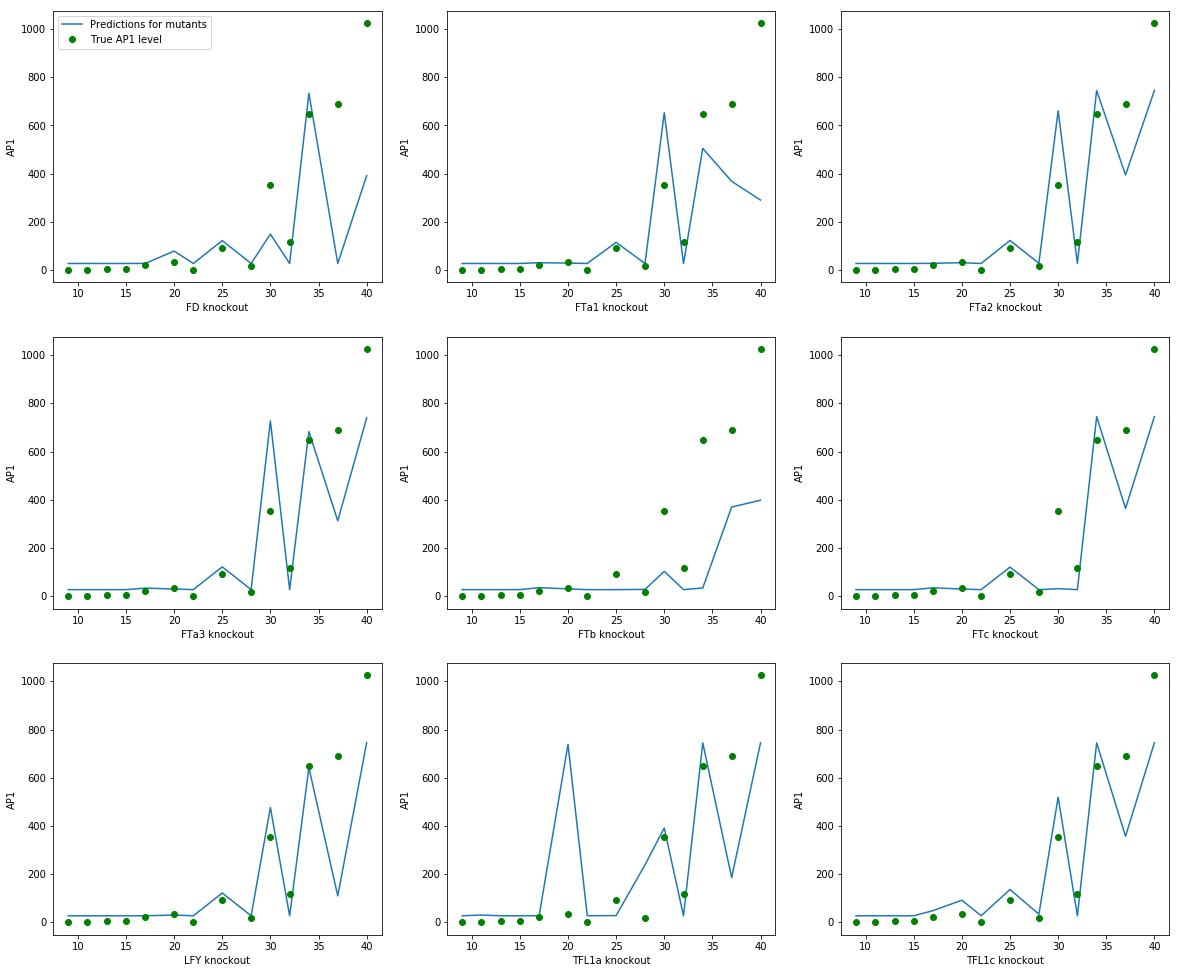

In [471]:
plt.figure(figsize=(20, 17))
plt.title('LD conditions')
for i in range(9):
    gene = X_test_standartized.keys()[i]
    plt.subplot(3, 3, i+1)
    plt.plot(true_lvls_LD['d'], mutants_out_LD[gene])
    plt.plot(true_lvls_LD['d'], true_lvls_LD['AP1'], 'go')
    plt.xlabel(gene + ' knockout')
    plt.ylabel('AP1')
    
    if i == 0:
        plt.legend(['Predictions for mutants', 'True AP1 level'])

plt.show()

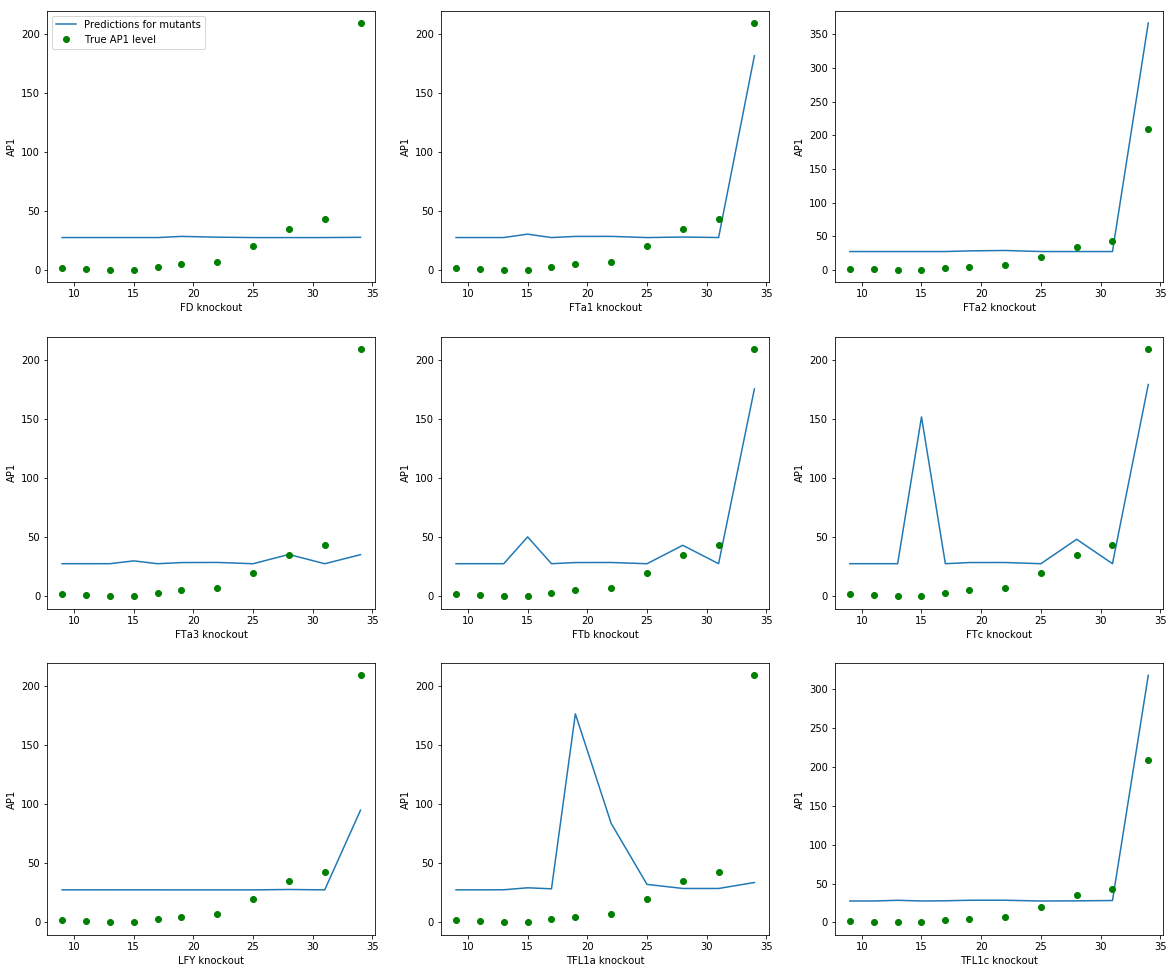

In [472]:
plt.figure(figsize=(20, 17))
plt.title('LD conditions')
for i in range(9):
    gene = X_test_standartized.keys()[i]
    plt.subplot(3, 3, i+1)
    plt.plot(true_lvls_SD['d'], mutants_out_SD[gene])
    plt.plot(true_lvls_SD['d'], true_lvls_SD['AP1'], 'go')
    plt.xlabel(gene + ' knockout')
    plt.ylabel('AP1')
    
    if i == 0:
        plt.legend(['Predictions for mutants', 'True AP1 level'])

plt.show()

In [476]:
integrate_level_AP1_LD = np.trapz(true_lvls_LD['AP1'])
integrate_level_AP1_SD = np.trapz(true_lvls_SD['AP1'])

integrate_levels_mutant_LD = {}
integrate_levels_mutant_SD = {}

for k in mutants_out_SD.keys():
    integrate_levels_mutant_SD[k] = np.trapz(mutants_out_SD[k]).round(2)
    integrate_levels_mutant_LD[k] = np.trapz(mutants_out_LD[k]).round(2)

In [481]:
for key, value in sorted(integrate_levels_mutant_SD.items(), key=lambda item: item[1], reverse = True):
    print("%s:\t %s" % (key, value.round(3)))

print('True level', integrate_level_AP1_SD)

FTc:	 498.2
TFL1a:	 493.56
FTa2:	 447.69
TFL1c:	 424.37
FTb:	 389.77
FTa1:	 357.74
LFY:	 309.54
FTa3:	 291.6
FD:	 276.82
True level 219.5


In [482]:
for key, value in sorted(integrate_levels_mutant_LD.items(), key=lambda item: item[1], reverse = True):
    print("%s:\t %s" % (key, value.round(3)))
    
print('True level', integrate_level_AP1_LD)

TFL1a:	 2885.02
FTa2:	 2535.62
FTa3:	 2458.95
TFL1c:	 2458.72
FTa1:	 2025.76
LFY:	 1961.26
FTc:	 1879.32
FD:	 1514.96
FTb:	 982.04
True level 2504.5
